In [1]:
# lets get the catalogue
#import eqcatana as eqc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pyslabgrid import slabgridding as slg
from pyslabgrid import eqcatana as eqc

deg2km = 111.19492664455873
km2deg = 0.008993216059187306

#### Spatial Gaussian smoothing 

We refer the present apporach as quasi-3D approach. The analysis is actually perform in 2D asis generally done with shallow crustal earthquakes. However, it honors the slab geometry through key steps: 

(1) delineation of mid-slab, 

(2) orthogonal projections of hypocentres onto the mid-slab, 

(3) generation of a uniform grid of 0.1° on the mid-slab and 

(4) application of gaussian smoothing. 

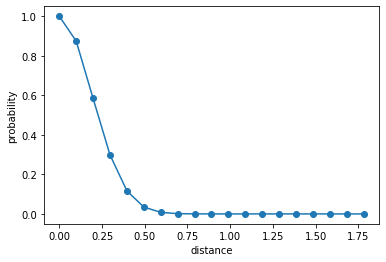

In [2]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
import pyslabgrid.mat as mat
cdic = mat.getdict('../pyslabgrid/slipcolor.mat')
newcolors = cdic['slipcolor']
slipcolormap = ListedColormap(newcolors)

def get_inpolgyon(dataxy, polygonxy):
    x,y = dataxy
    blon, blat = polygonxy
    points = np.vstack((x,y)).T 
   # blon, blat = polygon
    tupVerts = []
    for tx,ty in zip(blon, blat):
        tupVerts.append((tx,ty))
    pbounds = Path(tupVerts) # make a polygon
    indx = pbounds.contains_points(points)
    return indx

def distance_Euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def get_pgauss(d, corr_distance= 0.2697964817756192):
    #corr_distance= 0.2697964817756192): 30 km
    #corr_distance= 0.4496608029593653):
    # corr_distance = 50*km2deg # 50 km
    ksquare = (d/corr_distance)**2
    return np.exp(-ksquare)

# see the gaussin function
distances = [d for d in np.arange(0,200*km2deg, 11*km2deg)]
pguasses = []
for d in distances: 
    pguasses.append(get_pgauss(d))

plt.plot(distances, pguasses, 'o-')
plt.xlabel('distance')
plt.ylabel('probability');

In [3]:
def get_smoothseismictymodel(slabzone, catalog, doplot=False):
    zonename ={
        'hik-whole': 'Hikurangi-whole',
        'puy-whole': 'Puysegur-whole',
    }
    grid_file = {'hik-whole':'../04mid-slab/grids/hik_11km_meshed-midslabgrids.csv',
             'puy-whole': '../04mid-slab/grids/puy_11km_meshed-midslabgrids.csv',}
    lon, lat, mag = slg.read_catalog(catalog, min_year=1990, \
                             min_mag=4.0, slabzone = slabzone, decimate=1)
    x,y,z,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4 = slg.read_meshgrid(grid_file[slabzone])
    zx, zy = eqc.get_zonepolygon(slabzone)
    zoneVerts = []
    for tx,ty in zip(zx, zy):
        zoneVerts.append((tx,ty))
    pzone = Path(zoneVerts)
    points = np.vstack((lon,lat)).T 
    lon, lat = np.array(lon), np.array(lat)
    xcount, xlon, xlat, xdep = [],[],[],[]

    for i in range(len(x)):
        #plt.plot(x[i],y[i],'o')
        zin = pzone.contains_points( np.vstack((x[i],y[i])).T)
        if sum(zin)==0:
            continue
    
        xx = [x1[i],x2[i], x3[i], x4[i], x1[i]]
        yy = [y1[i],y2[i], y3[i], y4[i], y1[i]]
        tupVerts=[(x1[i], y1[i]), (x2[i], y2[i]), (x3[i], y3[i]), 
              (x4[i], y4[i]), (x1[i], y1[i]),]
        p = Path(tupVerts) # make a polygon
        IN = p.contains_points(points)
        xcount.append(sum(IN))
        xlon.append(x[i])
        xlat.append(y[i])
        xdep.append(z[i]*km2deg)
    if doplot:
        plt.scatter(xlon, xlat, c= xcount, cmap='jet');
        plt.colorbar();
        plt.show()
        

    # we have xlon, xlat, xdep, xcount to get the Gaussian smoothened
    max_distance = 200*km2deg
    smoothcount = []
    for kx,ky,kz in zip(xlon, xlat, xdep):
        # for each point, grab all the locations within 200 km
        # I am using Elucidian distances for speed - it's good approximation
        lcount = 0
        pguass = 0
        for tx, ty, tz, tcount in zip(xlon, xlat, xdep, xcount):
            tdist = distance_Euclidean([kx,ky, kz],[tx,ty, kz])
            if tdist>max_distance:
                # outside the scope
                continue
            p = get_pgauss(tdist, corr_distance= 0.4496608029593653)
            lcount = lcount+ p*tcount
            pguass = pguass + p
        
        smoothcount.append(lcount/pguass)
        
    spatp = [round(k/sum(smoothcount), 10) for k in smoothcount]
    if doplot:
        plt.scatter(xlon, xlat, c= spatp, cmap=slipcolormap);
        plt.colorbar();
        
    return(xlon, xlat, xdep, spatp)

In [4]:
grid_file = {'hik-whole': '../04mid-slab/grids/hik_11km_grids.csv', 
             'puy-whole': '../04mid-slab/grids/puy_11km_grids.csv'}
declustered_catalog = 'Grue_NZeqcat_Rollins13042020SEPI-subd-slab-proj2midslab.csv'
slabzone = 'puy-whole'
xlon_puy, xlat_puy, xdep_puy, rate_puy = get_smoothseismictymodel(slabzone, declustered_catalog);
slabzone = 'hik-whole'
xlon_hik, xlat_hik, xdep_hik, rate_hik = get_smoothseismictymodel(slabzone, declustered_catalog);

In [5]:
# write out
def write_out(filename, X,Y,Z, R):
    with open(filename, 'w') as f:
        f.write('lon,lat,dep,rate')
        for x,y,z,r in zip(X, Y, Z, R):
            f.write('\n%.4f,%.4f,%.4f,%.10f' %(x,y,z,r))
#
write_out('puy-slab-smooth_lay2.csv', xlon_puy, xlat_puy, xdep_puy, rate_puy)
write_out('hik-slab-smooth_lay2.csv', xlon_hik, xlat_hik, xdep_hik, rate_hik)
xlon = xlon_puy+xlon_hik
xlat = xlat_puy+xlat_hik
xdep = xdep_puy+xdep_hik
xrate = rate_puy+rate_hik

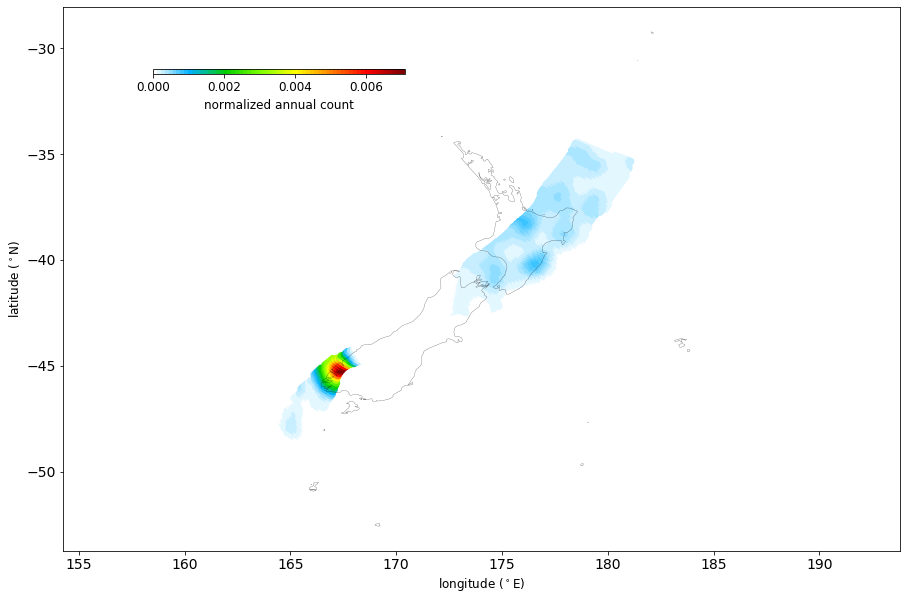

In [6]:
%matplotlib inline
import nzborders as nzb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(xlon, xlat, c= xrate,cmap=slipcolormap);
cbaxes = inset_axes(ax, width="3000%", height="5%", \
                    loc='upper left',
                    bbox_to_anchor=(0.1, 1-0.3, .01,.2), bbox_transform=ax.transAxes) 
#  bbox_to_anchor=(0.03, 1-0.7, .01,.6), 
cbar = fig.colorbar(sc, cax=cbaxes, shrink=1.0, orientation="horizontal")
cbar.ax.get_xaxis().labelpad = 5
cbar.ax.set_xlabel('normalized annual count', fontsize=12)
cbar.ax.tick_params(labelsize=12)

nzb.plot(file='nzborders.json', plinewidth= 0.2, pcolor = 'k', ax=ax)
ax.set_xlim([160, 185])
ax.axis('equal');

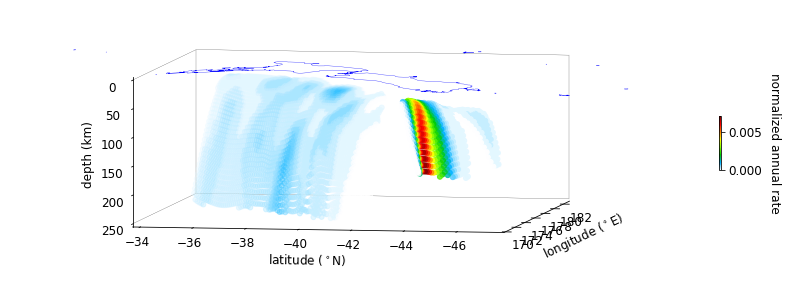

In [14]:
%matplotlib inline
plt.rcParams.update({'font.size': 12})
from mpl_toolkits.mplot3d import Axes3D
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')

ddep = [d*deg2km for d in xdep]
sc = ax.scatter(xlon, xlat, ddep, c= xrate, s=25,cmap=slipcolormap)
cbar = fig.colorbar(sc, ax=ax, shrink=0.2)
cbar.ax.get_yaxis().labelpad = 19
cbar.ax.set_ylabel('normalized annual rate', rotation=270)

ax.set_proj_type('ortho')
#ax.tricontourf(xlon, xlat, ddep, 10, linewidths=0.5)
grid_file = {'hik-whole': '../4MidSlab/grids/hik_11km_grids.csv', 
             'puy-whole': '../4MidSlab/grids/puy_11km_grids.csv'}

import json

with open("nzborders.json") as f:
    border = json.load(f)
zerodepth = [0]*len(border['lat'])
ax.plot3D(border['lon'], border['lat'], zerodepth, '-', \
          linewidth= 0.3, color='b', zorder=10)
ax.grid(b=None)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#ax.set_box_aspect((1, 1, 0.3))

ax.plot3D([170, 183, 183], [-33.7, -33.7, -47.8], [0, 0, 0], \
          '-', color = 'k',linewidth=0.2)
ax.plot3D([170, 183, 183], [-33.7, -33.7, -47.8], [250, 250, 250], \
          '-', color = 'k',linewidth=0.2)
ax.plot3D([183, 183], [-47.8, -47.8], [0, 250], '-', color = 'k',linewidth=0.2)
ax.plot3D([183, 183], [-33.7, -33.7], [0, 250], '-', color = 'k',linewidth=0.2)
ax.set_zlim(0, 250)
ax.set_ylim([-47.5,-34])
ax.set_xlim([170,183])
ax.invert_zaxis()
ax.view_init(elev=12, azim=190)

ax.set_xlabel('longitude ($^\circ$E)', fontsize=12, labelpad=10)
ax.set_ylabel('latitude ($^\circ$N)', fontsize=12, labelpad=20)
ax.zaxis.set_rotate_label(False)  
ax.set_zlabel('depth (km)', fontsize=12, rotation=90);

#ax.grid(False)